https://www.thesgc.org/sites/default/files/tep/NUDT7_TEP_datasheet_v3.pdf
https://pubs.acs.org/doi/10.1021/jacs.9b02822
https://ezproxy-prd.bodleian.ox.ac.uk:3176/doi/full/10.1002/cmdc.202000543

deposition group G_1002045 (JACS)

vanilla appears to be 5T3P, but let's use the base fragment as a template.

"four compounds labeling 100%" is this the Wilde-Nelson score thinggy?

The template has HYP and CSO in distant locations.
I would like to provide the params (out of completeness), but I am in a rush.
So next time. Although it does make a case against the generalised forcefield,
as these would crash it.

The following PDBs have two hits:
5QGK, 5QGN, 5QGR and 5QH3
These are of no importance so were not split (see PHIP-Fragmenstein for that process)

Annoyingly, the protein backbone PDBs were not quite aligned (~1 Å off).
TODO Ask Darren how this is possible in a PanDDA experiment.

The JACS paper has a merger, but I cannot figure out where did NU166 come from.

In [ ]:
import os
os.chdir('/Users/matteo/Coding/Fragmenstein-figures/NUDT7')

In [ ]:
# ## Download the deposition group

deposition_group_id:str = "G-1002045".replace("-","_")
# =============================================================================

from IPython.display import HTML
from pypdb.clients.search.search_client import perform_search
from pypdb.clients.search.search_client import ReturnType
from pypdb.clients.search.operators import text_operators
from typing import List, Dict, Any

# pdbx_deposit_group.group_id
search_operator = text_operators.ExactMatchOperator(value=deposition_group_id,
                                                    attribute="pdbx_deposit_group.group_id")
pdb_ids: List[str] = perform_search(search_operator, ReturnType.ENTRY)

print(f'Found {len(pdb_ids)} entries')

In [ ]:
# ## Get the Subject of Investigation
# I honestly do not know how to fish out the "Subject of Investigation"
# the website of the PDB has it... but not the API

import pyrosetta_help as ph
import pandas as pd
import operator
import requests
import re
from typing import List

# -------------------------------------------------------------------------------------------------------

# get all the cofactor codes
ligandhunter = ph.LigandHunter.__new__(ph.LigandHunter)
cofactor_codes = ligandhunter.cofactor_codes
cofactor_codes += ['GDP', 'MES', 'ACP', 'ACT', 'DMS']

def get_novel_comp_ids(pdb_id:str) -> List[str]:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{pdb_id.lower()}')
    response.raise_for_status()
    data = response.json()[pdb_id.lower()]
    comp_id_iter = map(operator.itemgetter('chem_comp_id'), data)
    return [comp_id for comp_id in comp_id_iter if comp_id not in cofactor_codes]

def get_first_novel_comp_id(pdb_id:str) -> str:
    comp_ids:List[str] = get_novel_comp_ids(pdb_id)
    return comp_ids[0] if comp_ids else ''

def get_ligand_data(ligand_resn:str) -> Dict[str, Any]:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/compound/summary/{ligand_resn}')
    response.raise_for_status()
    return response.json()[ligand_resn.upper()][0]

def get_title(pdb_id:str) -> str:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/summary/{pdb_id.lower()}')
    response.raise_for_status()
    data = response.json()[pdb_id.lower()]
    return data[0]["title"]

def get_compound_name_in_title(title:str) -> str:
    if 'in complex with ' in title:  # it;s a panDDA deposition...
        return re.search(r'in complex with ([\w\-]+)', title).group(1)
    else:
        print('title issue for: ', title)
        return '-'
# -------------------------------------------------------------------------------------------------------

metadata = pd.DataFrame([dict(pdb_id=pdb_id, type='hit') for pdb_id in pdb_ids])

# download pdbs
metadata['pdb_filename'] = metadata.pdb_id.apply(ph.download_pdb)
# get ligand
metadata['ligand_resn'] = metadata.pdb_id.apply(get_first_novel_comp_id)
# ## get ligand info
response_data = metadata.ligand_resn.apply(get_ligand_data)
metadata['chembl_id'] = response_data.apply(operator.itemgetter('chembl_id'))
metadata['formal_charge'] = response_data.apply(operator.itemgetter('formal_charge'))
metadata['SMILES'] = response_data.apply(lambda d: d['smiles'][0]['name'])
metadata['systematic_name'] = response_data.apply(lambda d: d['systematic_names'][0]['name'])
# ## get the title from the PDB
metadata['title'] = metadata.pdb_id.apply(get_title)
metadata['title_name'] = metadata.title.apply(get_compound_name_in_title)

In [ ]:
# ## Let;s add the papername
# There is generally a hidden spreadsheet with this detail, but I cannot find it.

metadata['paper_name'] = metadata.pdb_id.map({
                                 '5QHH': 'NU443',
                                 '5QGM': 'Compound 3A',
                                 '5QHC': 'Compound 3C',
                                 '5QHB': 'Compound 3D',
                                 '5QHE': 'Compound 3F',
                                 '5QH1': 'NU181',
                                })

# I could add failed compounds:

# 3A COc1ccc(cc1)c2ccccc2N3CCCC3=O
# 3B F(F)(F)Cc1ccc(cc1)c2ccccc2N3CCCC3=O
# 3E O=[N+]([O-])c1ccc(cc1)c2ccccc2N3CCCC3=O

In [ ]:
# ## Fix Smiles that are not convalent but just dud

metadata.at[metadata.loc[metadata.title_name == 'PCM-0102558'].index[0],
           'SMILES'] = 'COc1ccc(cc1)[C@@H]2CC=CCCN2C(C*)=O'
metadata.at[metadata.loc[metadata.title_name == 'PCM-0102716'].index[0],
           'SMILES'] = 'COc1cccc(c1)[C@@H]2CCCN2C(C*)=O'
metadata.at[metadata.loc[metadata.title_name == 'PCM-0102951'].index[0],
           'SMILES'] = '*CC(=O)NC1(CCCC1)c2ccc3OCCOc3c2'
metadata.at[metadata.loc[metadata.title_name == 'NU000443a'].index[0],
           'SMILES'] = '*CC(=O)N1CCC[C@H]1c2cccc(CC(=O)Nc3cccc(Cl)c3)c2'

In [11]:
## What are the targets like:

metadata.loc[metadata.pdb_id.isin(['5QH8', '5QH9', '5QHA', '5QHH'])]

,pdb_id,type,pdb_filename,ligand_resn,chembl_id,formal_charge,SMILES,systematic_name,title,title_name,paper_name,pdb_al_filename,mol
28,5QH8,hit,5qh8.pdb,H0A,None,0,COc1ccc(cc1)[C@@H]2CC=CCCN2C(C*)=O,"1-[(2S)-2-(4-methoxyphenyl)-2,3,6,7-tetrahydro...",PanDDA analysis group deposition of models wit...,PCM-0102558,NaN,5qh8.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7fa9c3dacb30>
29,5QH9,hit,5qh9.pdb,GZY,None,0,COc1cccc(c1)[C@@H]2CCCN2C(C*)=O,1-[(2S)-2-(3-methoxyphenyl)pyrrolidin-1-yl]eth...,PanDDA analysis group deposition of models wit...,PCM-0102716,NaN,5qh9.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7fa9c3dacb80>
30,5QHA,hit,5qha.pdb,H3D,None,0,*CC(=O)NC1(CCCC1)c2ccc3OCCOc3c2,"N-[1-(2,3-dihydro-1,4-benzodioxin-6-yl)cyclope...",PanDDA analysis group deposition of models wit...,PCM-0102951,NaN,5qha.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7fa9c3dacbd0>
36,5QHH,hit,5qhh.pdb,H5D,None,0,*CC(=O)N1CCC[C@H]1c2cccc(CC(=O)Nc3cccc(Cl)c3)c2,2-{3-[(2S)-1-acetylpyrrolidin-2-yl]phenyl}-N-(...,PanDDA analysis group deposition of models wit...,NU000443a,NU443,5qhh.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7fa9c3dacdb0>


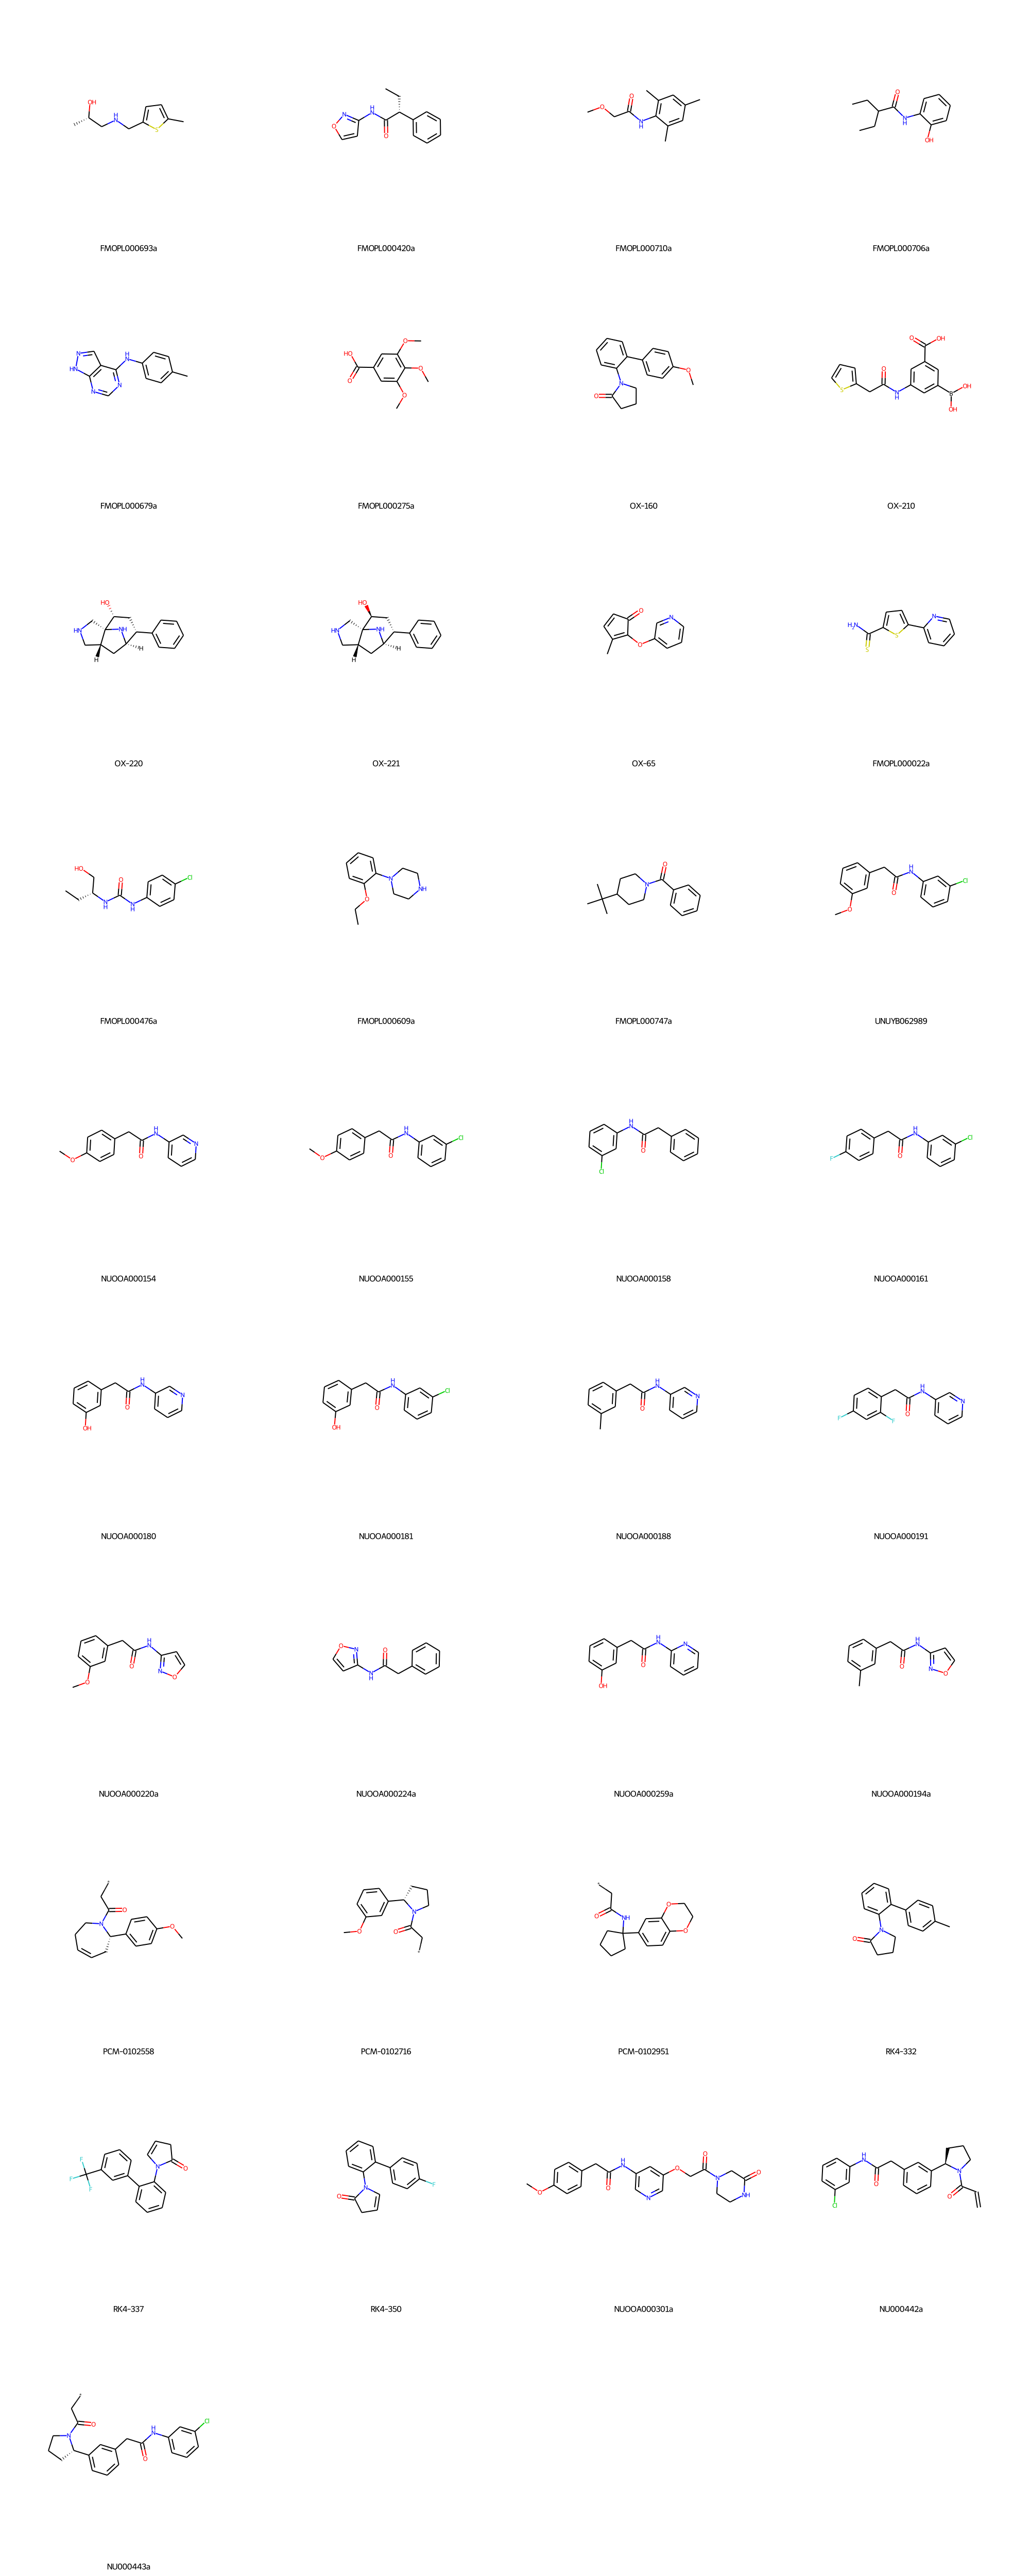

In [14]:
## All toghether

from rdkit import Chem

Chem.Draw.MolsToGridImage(metadata.SMILES.apply(Chem.MolFromSmiles).to_list(),
                          molsPerRow=4, maxMols=100,
                          subImgSize=(500, 500),
                          useSVG=False,
                         legends=metadata.title_name.to_list())

In [ ]:
import pyrosetta
import pyrosetta_help as ph
from fragmenstein import Victor, Laboratory, Igor

Igor.init_pyrosetta()

#pose = pyrosetta.toolbox.pose_from_rcsb('5QH1')
pose = pyrosetta.pose_from_file('5QH1.clean.pdb')
scorefxn = pyrosetta.get_fa_scorefxn()
cycles = 5

relax = pyrosetta.rosetta.protocols.relax.FastRelax(scorefxn, cycles)
movemap = pyrosetta.MoveMap()
movemap.set_bb(True)
movemap.set_chi(True)
relax.set_movemap(movemap)
pyrosetta.rosetta.protocols.relax.add_coordinate_constraints_to_pose(pose,
                                                                     pose.clone(),
                                                                    pyrosetta.rosetta.protocols.loops.Loops())

scorefxn.set_weight(pyrosetta.rosetta.core.scoring.ScoreType.coordinate_constraint, 1)
relax.apply(pose)
template_block = ph.get_pdbstr(pose)
pose.pdb_info().obsolete(False)
pose.dump_pdb('template.pdb')

In [ ]:
import pymol2

PDB_unaligned_RMSD = []
with pymol2.PyMOL() as pymol:
    pymol.cmd.load('template.pdb', 'template')
    for filename in metadata.pdb_filename:
        pymol.cmd.load(filename, 'mobile')
        out = pymol.cmd.align('mobile', 'template')
        PDB_unaligned_RMSD.append(out[3])
        mod_filename = filename.replace('.pdb', '.al.pdb')
        pymol.cmd.save(mod_filename, 'mobile')
        pymol.cmd.delete('mobile')
        # LINK migration
        with open(filename, 'r') as fh:
            block = fh.read()
            for line in block.split('\n'):
                if 'LINK   ' not in line:
                    continue
                if 'HYP' in line:
                    continue
                if 'CSO' in line:
                    continue
                if 'LINK' in block:
                    with open(mod_filename, 'r') as fh:
                        block = fh.read()
                    with open(mod_filename, 'w') as fh:
                        fh.write(line+'\n'+block)

In [0]:
metadata['pdb_al_filename'] = metadata.pdb_filename.str.replace('.pdb', '.al.pdb')

In [ ]:
# extract mols
from rdkit import Chem, IPythonConsole
from fragmenstein import Victor

metadata['mol'] = metadata.apply(lambda row: Victor.extract_mol(name=row.title_name,
                                             ligand_resn=row.ligand_resn,
                                             filepath=row.pdb_al_filename,
                                             smiles=row.SMILES,
                                             throw_on_error=True
                                            ),
                                   axis=1)

In [ ]:
metadata.to_pickle('metadata.p')
metadata.drop(columns=['mol']).to_csv('metadata.csv')

In [16]:
metadata

,pdb_id,type,pdb_filename,ligand_resn,chembl_id,formal_charge,SMILES,systematic_name,title,title_name,paper_name,pdb_al_filename,mol
0,5QGG,hit,5qgg.pdb,H2G,None,0,C[C@H](O)CNCc1sc(C)cc1,(2S)-1-{[(5-methylthiophen-2-yl)methyl]amino}p...,PanDDA analysis group deposition of models wit...,FMOPL000693a,NaN,5qgg.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cb9f0>
1,5QGH,hit,5qgh.pdb,H2D,None,0,CC[C@@H](C(=O)Nc1ccon1)c2ccccc2,"(2R)-N-(1,2-oxazol-3-yl)-2-phenylbutanamide",PanDDA analysis group deposition of models wit...,FMOPL000420a,NaN,5qgh.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cb9a0>
2,5QGI,hit,5qgi.pdb,B0V,None,0,COCC(=O)Nc1c(C)cc(C)cc1C,"2-methoxy-~{N}-(2,4,6-trimethylphenyl)ethanamide",PanDDA analysis group deposition of models wit...,FMOPL000710a,NaN,5qgi.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cba90>
3,5QGJ,hit,5qgj.pdb,H1A,None,0,CCC(CC)C(=O)Nc1ccccc1O,2-ethyl-N-(2-hydroxyphenyl)butanamide,PanDDA analysis group deposition of models wit...,FMOPL000706a,NaN,5qgj.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cbae0>
4,5QGK,hit,5qgk.pdb,H0S,None,0,Cc1ccc(Nc2ncnc3[nH]ncc23)cc1,"N-(4-methylphenyl)-1H-pyrazolo[3,4-d]pyrimidin...",PanDDA analysis group deposition of models wit...,FMOPL000679a,NaN,5qgk.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cbb30>
5,5QGL,hit,5qgl.pdb,H5A,None,0,COc1cc(cc(OC)c1OC)C(O)=O,"3,4,5-trimethoxybenzoic acid",PanDDA analysis group deposition of models wit...,FMOPL000275a,NaN,5qgl.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cbb80>
6,5QGM,hit,5qgm.pdb,H4Y,None,0,COc1ccc(cc1)c2ccccc2N3CCCC3=O,"1-(4'-methoxy[1,1'-biphenyl]-2-yl)pyrrolidin-2...",PanDDA analysis group deposition of models wit...,OX-160,Compound 3A,5qgm.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d79cbd60>
7,5QGN,hit,5qgn.pdb,H4D,None,0,OB(O)c1cc(NC(=O)Cc2sccc2)cc(c1)C(O)=O,3-borono-5-{[(thiophen-2-yl)acetyl]amino}benzo...,PanDDA analysis group deposition of models wit...,OX-210,NaN,5qgn.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d7cee7c0>
8,5QGO,hit,5qgo.pdb,H4A,None,0,O[C@@H]1C[C@@H]([C@H]2C[C@@H]3CNC[C@@]13N2)c4c...,"(3aR,4R,6R,7R,8aR)-6-phenyloctahydro-1H-3a,7-e...",PanDDA analysis group deposition of models wit...,OX-220,NaN,5qgo.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d7e05f90>
9,5QGP,hit,5qgp.pdb,H3Y,None,0,O[C@H]1C[C@@H]([C@H]2C[C@@H]3CNC[C@@]13N2)c4cc...,"(3aR,4S,6R,7R,8aR)-6-phenyloctahydro-1H-3a,7-e...",PanDDA analysis group deposition of models wit...,OX-221,NaN,5qgp.al.pdb,<rdkit.Chem.rdchem.Mol object at 0x7f99d7ce8ae0>


PyRosetta-4 2022 [Rosetta PyRosetta4.conda.mac.cxx11thread.serialization.python38.Release 2022.12+release.a4d79705213bc2acd6b51e370eddbb2738df6866 2022-03-20T21:59:37] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


ligand - Folder output/ligand exists.


*CC(=O)N1CCC[C@H]1c1cccc(CC(=O)Nc2cccc(Cl)c2)c1


[12:02:05] UFFTYPER: Unrecognized atom type: *_ (0)
[12:02:05] UFFTYPER: Unrecognized atom type: *_ (0)
[12:03:17] UFFTYPER: Unrecognized atom type: *_ (45)
[12:03:17] Molecule does not have explicit Hs. Consider calling AddHs()
[12:03:17] UFFTYPER: Unrecognized atom type: *_ (45)
[12:03:17] Molecule does not have explicit Hs. Consider calling AddHs()


[]


In [7]:
victor.validate(NU443)

{'minimized2hits_rmsd': 0.6607401508496568,
 'reference2hits_rmsd': 0.6053578288191233,
 'reference2minimized_rmsd': 0.283216848842669}

In [ ]:
victor.monster.show_comparison()

In [9]:
view = victor.to_nglview()
view.add_mol(NU443)
view

MolNGLWidget()

In [11]:
victor.make_pse('output.pse')

In [7]:
# ## Random test
# this is horrible as the two oxygens result in a closed ring.
victor = Victor([NU181, PCM0102716, ], pdb_filename='template.pdb',
                covalent_resi='73A', covalent_resn='CYS')
#victor.enable_stdout(10)
victor.combine(long_name='combo')

In [ ]:
victor.monster.draw_nicely(victor.params.mol)